In [1]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
#import src.ImageEncode as ie
rc('text', usetex=False)
rc('axes', linewidth=3)

from PIL import Image

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [3]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

GPU: NVIDIA GeForce RTX 4080 is available.


In [2]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = abs(np.random.randn(n_train,n))+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states

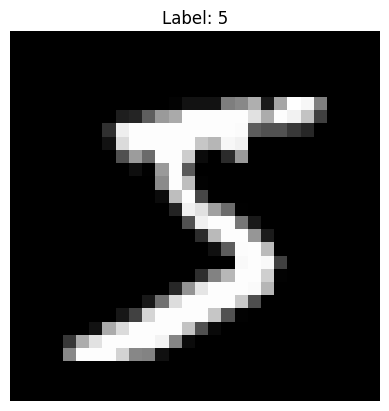

In [4]:
#import torch
from torchvision import datasets, transforms
#import matplotlib.pyplot as plt

# Define a transform to convert the data to tensors
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Access a sample image
image, label = train_dataset[0]
np_image = image.detach().numpy()
np.save("MNIST_data", np_image)

# Plot the image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

107.94118


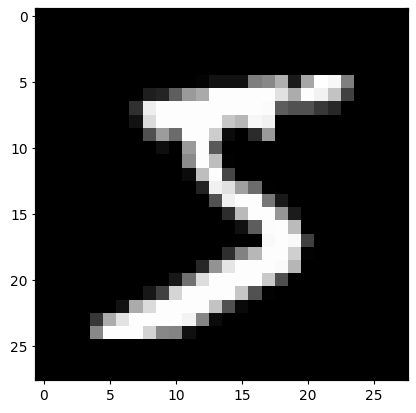

In [6]:
from PIL import Image
scale = 40
img_array = np.load('MNIST_data.npy')

dim_y = np.size(img_array[0], 0)
dim_x = np.size(img_array[0], 1)
num_pixels = img_array[0].size

num_qubits = int(math.ceil(math.log2(img_array[0].size)))
num_states = 2 ** num_qubits
norm_factor = np.sum(img_array[0])
print(norm_factor)

angle_encoded_MNIST = np.zeros(num_states) + 1j * np.zeros(num_states)

for i in range(num_states): #encode s.t. absolute value squared of state is pixel value
    if(i < num_pixels):
        angle_encoded_MNIST[i] = (img_array[0][int(i / dim_y)][i % dim_x] / norm_factor) ** 0.5 + 0j
    else: 
        angle_encoded_MNIST[i] = 0 + 0j


plt.imshow(img_array[0], cmap='grey', interpolation = 'nearest')


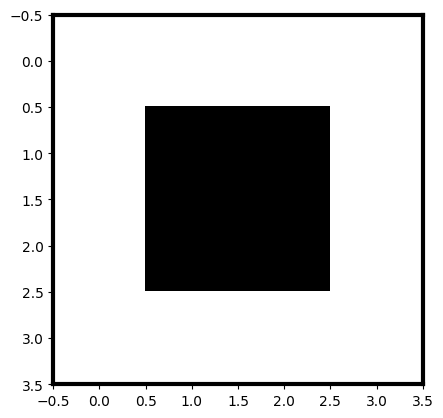

In [6]:
#Square 4 by 4 to add noise and turn into training data
temp_test = np.array([[1, 1, 1, 1], [1, 0, 0, 1], [1, 0, 0, 1], [1, 1, 1, 1]])
plt.imshow(temp_test, cmap='grey',interpolation = 'nearest')
temp_test = temp_test.flatten()


In [15]:
#generate training data for diffusion
n = 4#num_qubits
T = 25
Ndata = 15000

diff_hs = torch.from_numpy(np.linspace(0.5, 4., T)).to(torch.device("cuda"))

model_diff = DiffusionModel(n, T, Ndata)
data_to_diffuse = generate_training(temp_test, Ndata, 0.09) #np.zeros((Ndata, 2**n)) + 1j * np.zeros((Ndata, 2**n))
#for i in range(Ndata):
#    data_to_diffuse[i] = angle_encoded_MNIST
X = torch.from_numpy(data_to_diffuse).to(torch.device("cuda"))

np.save('training_data', np.array(data_to_diffuse))

(15000, 16)
(16,)


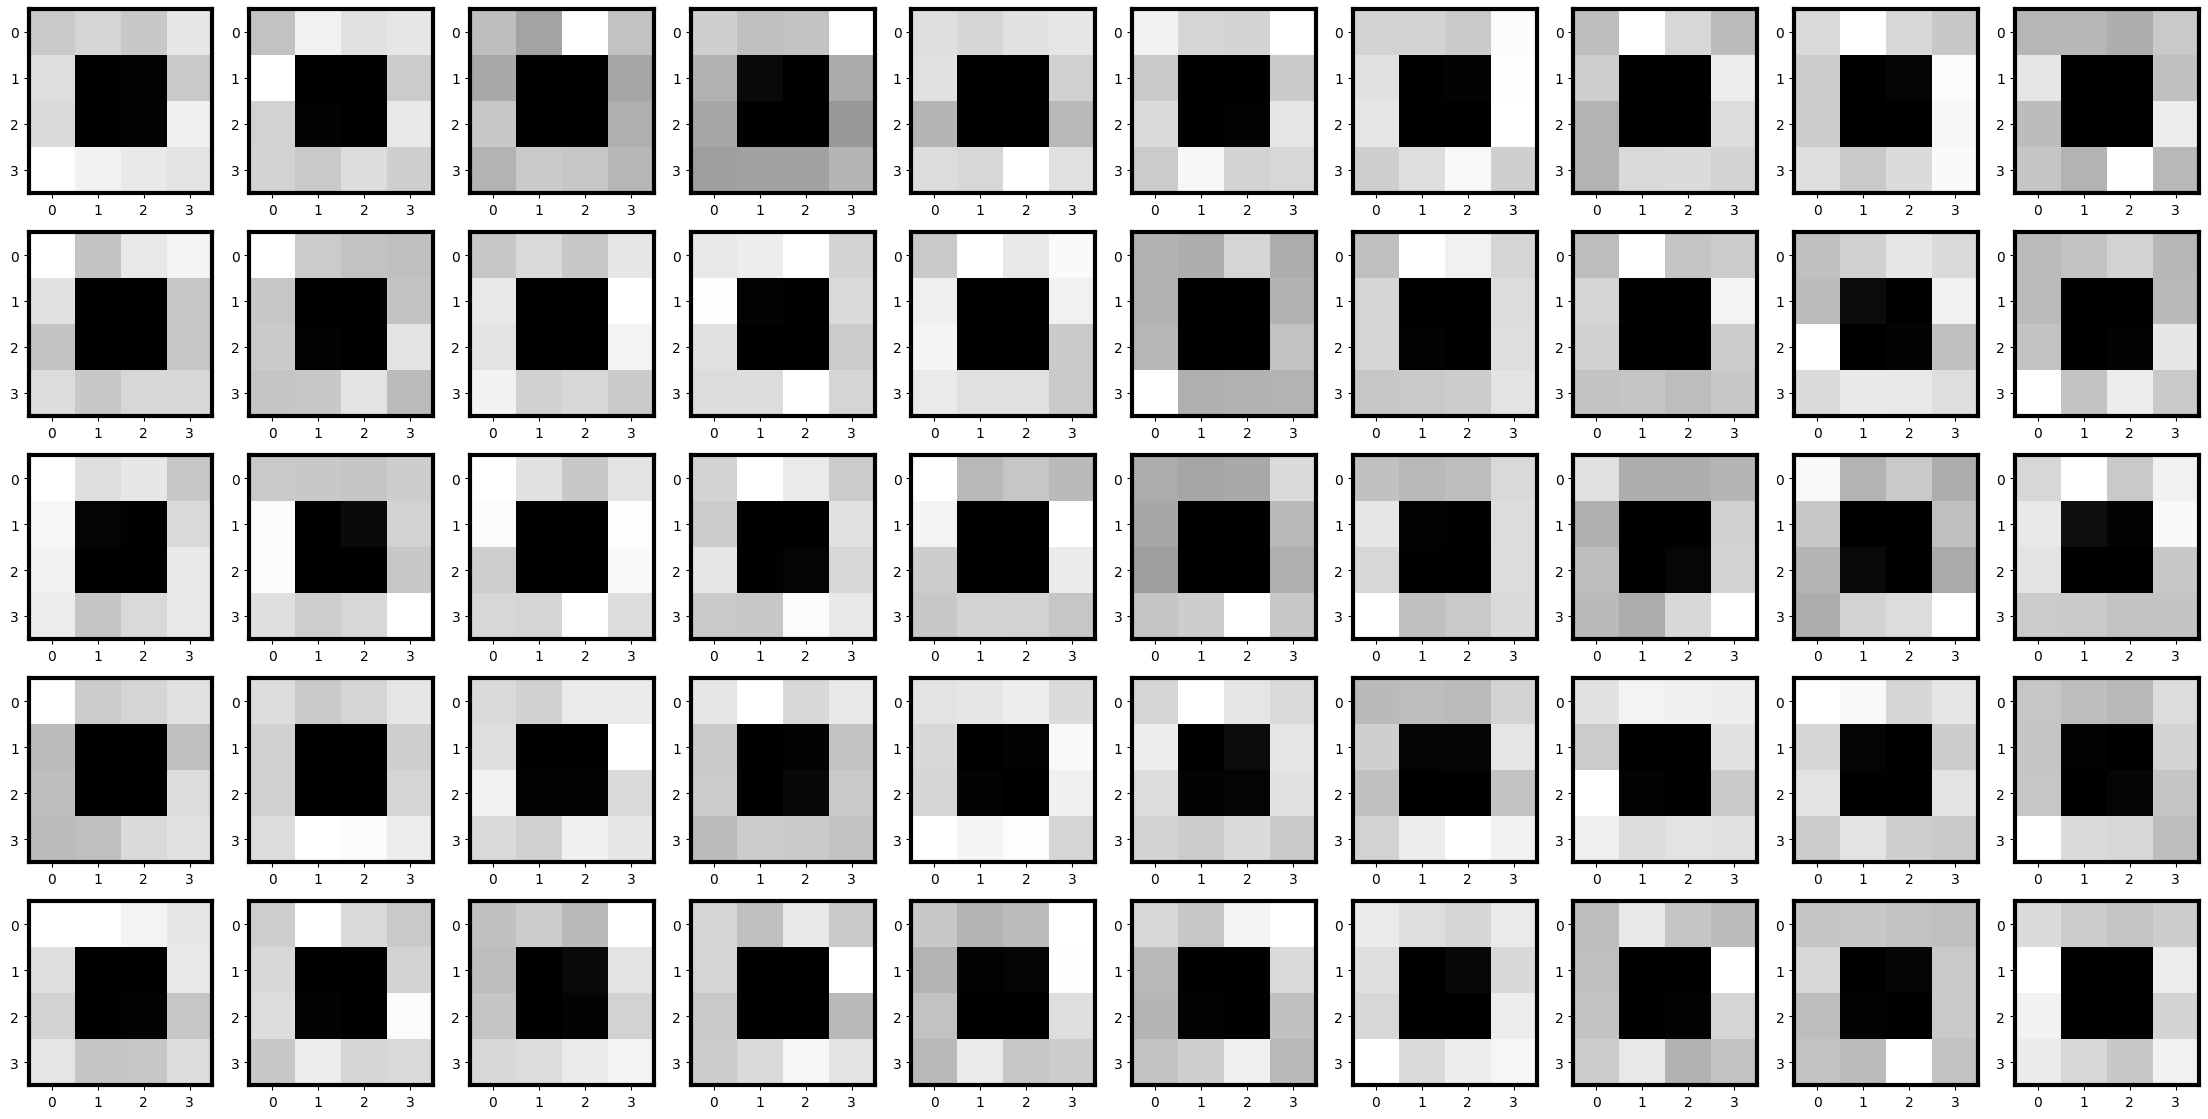

In [16]:
#visualize training data before they are forward diffused
training_temp = np.abs(np.array(data_to_diffuse)) ** 2
multiplier = np.max(training_temp)
training_temp /= multiplier
fig, axs = plt.subplots(5, 10, figsize = (28, 14))
dim = int((2 ** n) ** 0.5)
for index_1 in range(50):
    training_images = training_temp[index_1]

    picture_training  = np.zeros((dim, dim))
    for i in range(0, dim):
        for j in range(0, dim):
            picture_training[i][j] = training_images[i*dim + j]

    axs[int(index_1 / 10)][index_1 % 10].imshow(picture_training, cmap='grey',interpolation = 'nearest')

In [21]:
#diffuse training data
Xout = torch.from_numpy(np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)).to(torch.device("cuda"))
Xout[0] = X

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t)
    print(t)

Xout = Xout.cpu()
np.save("states_diff", Xout)

1
2


KeyboardInterrupt: 

In [8]:
#calculate fidelity of forward diffusion
from scipy.linalg import sqrtm

states_diff = np.load('states_diff.npy')

fidelity = np.zeros((T + 1, Ndata))
for i in range(0, T + 1):
    for j in range(0, Ndata):
        #different calculations for mixed state fidelity
        fidelity[i][j] = np.abs(np.vdot(states_diff[i][j], states_diff[0][j])) ** 2


fidelity_mean = np.mean(fidelity, axis = 1)
print(fidelity)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [0.94990863 0.98199854 0.94824535 ... 0.97288385 0.95979475 0.94737191]
 [0.90470809 0.87390971 0.91388044 ... 0.85731009 0.82591507 0.73957942]
 ...
 [0.04355648 0.03478771 0.07309675 ... 0.05457393 0.00391823 0.11142918]
 [0.1107851  0.07006927 0.01805886 ... 0.09572161 0.02255231 0.00151207]
 [0.00305082 0.16988366 0.11899722 ... 0.01180165 0.08800201 0.00101917]]


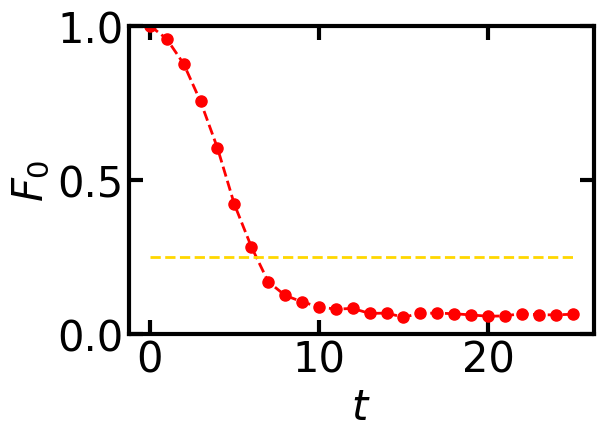

In [9]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 25
Ndata = 300
states_diff = np.load('states_diff.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(Ndata)

ax.plot(range(T+1), fidelity_mean, 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

In [3]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata)#.to(torch.device("cuda:0")) # prepare input
    #print("input_tplus1 is cuda: ", input_tplus1.is_cuda)
    states_diff = model.states_diff#.to(torch.device("cuda:0"))
    #print("states_diff is cuda: ", states_diff.is_cuda)
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)#, device = torch.device("cuda:0"))
    #print("params_t is cuda: ", params_t.is_cuda)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]#.to(torch.device("cuda:0"))
        #print("true_data is cuda: ", true_data.is_cuda)

        output_t = model.backwardOutput_t(input_tplus1, params_t)#.to(torch.device("cuda:0"))
        #print("output_t is cuda: ", output_t.is_cuda)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [12]:
device = torch.device("cpu")
print(device)

cpu


In [4]:
#train on diffused data
n, na = 4, 1 # number of data and ancilla qubits
T = 25 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 100 # number of data in the training data set
epochs = 2501


 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)#.to(device)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)#.to(device)
#print(inputs_T.is_cuda)

#load diffusion process
states_diff = np.load('states_diff.npy')


model = QDDPM(n=n, na=na, T=T, L=L)#.to(device)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, T):
        print(tt)
        params_tot[tt] = torch.from_numpy(np.load('paramsandloss_squaremodel/params_t%d.npy'%tt))#.to(device)
    
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('paramsandloss_squaremodel/params_t%d'%t, params.detach().numpy())
    loss_hist = loss_hist.to(torch.device("cpu"))
    np.save('paramsandloss_squaremodel/loss_t%d'%t, loss_hist.detach().numpy())
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(0.0346, device='cuda:0', grad_fn=<SubBackward0>), time elapsed: 0.2816042900085449 seconds
Step 100, loss: tensor(0.0308, device='cuda:0', grad_fn=<SubBackward0>), time elapsed: 3.462726354598999 seconds
Step 200, loss: tensor(0.0253, device='cuda:0', grad_fn=<SubBackward0>), time elapsed: 6.847626686096191 seconds
Step 300, loss: tensor(0.0270, device='cuda:0', grad_fn=<SubBackward0>), time elapsed: 10.036304712295532 seconds


KeyboardInterrupt: 

In [14]:
#save total parameters
n, na = 4, 1
T = 25
L = 6
Ndata = 100
epochs = 2500 + 1

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('paramsandloss_squaremodel/params_t%d.npy'%t)
    loss_tot[t] = np.load('paramsandloss_squaremodel/loss_t%d.npy'%t)
    

np.save("params_total_3000Ndata_35kEpochs", params_tot)
np.save("loss_tot_3000Ndata_35kEpochs", loss_tot)                            

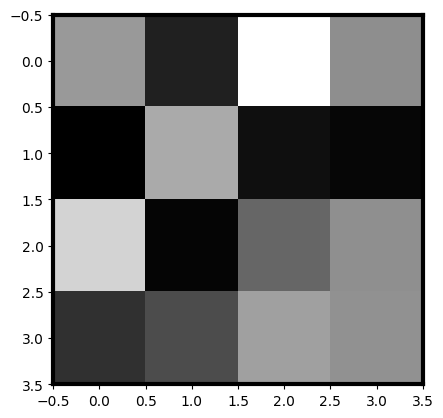

In [27]:
#create random 16 pixel data
Ndata = 2000
n = 4
random_images = np.zeros((Ndata, 4, 4))
amplitude_vals = np.zeros(Ndata)

for i in range(0, Ndata):
    random_images[i] = np.random.rand(4,4)
    amplitude_vals[i] = np.sum(random_images[i] ** 2) ** 0.5

plt.imshow(random_images[1], cmap = 'grey', interpolation = 'nearest')
np.save("random_images", random_images)

In [28]:
#Amplitude encode random image data into qubits
random_images_qubits = np.zeros((Ndata, 2**n)) + 1j * np.zeros((Ndata, 2**n))
for i in range(0, Ndata):
    random_images_qubits[i] = np.ravel(random_images[i] / amplitude_vals[i] + 0j)

#print(random_images_qubits)

In [30]:
#Run trained model on random image data
n, na = 4, 1
T = 21
L = 6
Ndata = 2000

params_tot = np.load('params_total_2000Ndata_20kEpochs.npy')

diffModel = DiffusionModel(n, T, Ndata)
inputs_te = diffModel.HaarSampleGeneration(Ndata, seed=22)

model = QDDPM(n=n, na=na, T=T, L=L)


#data_te = model.backDataGeneration(test_data_T20, params_tot, Ndata)[:, :, :2**n].numpy()
data_te = model.backDataGeneration(torch.from_numpy(random_images_qubits), params_tot, Ndata)[:, :, :2**n].cpu().numpy()

np.save("test_backwardsgen", data_te)

In [31]:
#from backwards_gen decode the qubit state to get the nxn image
backwards_gen = np.load('test_backwardsgen.npy')
dim = 4#int((final_output_flattened.size) ** 0.5)
final_output_nxn = np.zeros((T + 1, Ndata, dim, dim))

for z in range(0, T + 1):
    final_output_flattened = backwards_gen[z]
    final_output_flattened = np.abs(final_output_flattened)
    #multiplier = np.max(final_output_flattened)
    for i in range(0, np.size(amplitude_vals)):
        final_output_flattened[:][i] *= amplitude_vals[i]
    #final_output_flattened /= multiplier

    for i in range(0, dim):
        for j in range(0, dim):
            for nth_data in range(0, Ndata):
                final_output_nxn[z][nth_data][i][j] = final_output_flattened[nth_data][(i*dim) + j]


[[ 1.53234228e-03+1.11669407e-03j -5.53009193e-03+3.50004807e-03j
   5.84281702e-03-1.95184443e-03j -7.28075532e-03+8.12879857e-03j
  -1.73503254e-03+1.55592128e-03j -2.02459563e-03+1.10609562e-03j
   3.55166709e-03-4.06163232e-03j  7.64155178e-04+1.75490289e-03j
   2.61303619e-04+2.45389552e-03j -3.20171984e-03+2.01404025e-03j
   4.59336303e-03-3.45040602e-03j -3.24478582e-03+4.11070837e-03j
   1.17703492e-03-4.99338727e-04j -1.21116708e-03+3.15619051e-03j
  -4.90373524e-04-2.54681418e-05j -3.55652557e-03+5.70201874e-03j]
 [-7.64181651e-03-6.67320145e-03j -6.20153593e-03-5.07803541e-03j
  -5.94747253e-03-4.92409337e-03j -1.05497930e-02-1.47766317e-03j
  -4.48125275e-03-7.32358405e-03j -5.99163643e-04+1.06823561e-03j
   2.34090071e-03-5.37190214e-03j -6.26394339e-03-2.44582049e-03j
  -6.29425561e-03-5.36936196e-03j -2.51644233e-04+6.72209671e-06j
   3.38906160e-04-4.04187432e-03j -7.28573604e-03-7.13711313e-04j
  -6.32872805e-03-9.84594785e-03j -6.04872499e-03-4.81093815e-03j
  -6.1188

Text(0.5, 0, 'T')

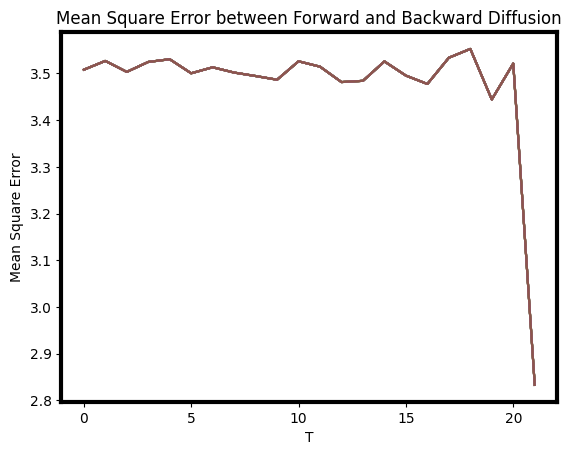

In [32]:
#Will change to showing loss instead of mean square error
#Xout[T][Ndata][2**n]
#backwards_gen[T][Ndata][2**n]
mse_calc = np.zeros((T + 1, 16))
avg_backwards_vector = np.sum(backwards_gen, axis = 1)/Ndata
print(avg_backwards_vector)

orig_vals = np.sum((np.load('training_data.npy')), axis = 0) / Ndata
#print(orig_vals)
for i in range(0, T + 1):
    temp1 = 0
    for j in range(0, 2**n):
        temp1 += (np.abs(orig_vals[j] - avg_backwards_vector[i][j]))**2
    #print(temp1)
    mse_calc[i] = temp1/ 16

#mse_calc = np.abs(np.sum(mse_calc, axis = 1)) / 16

plt.plot(range(0, T + 1), mse_calc)
plt.title("Mean Square Error between Forward and Backward Diffusion")
plt.ylabel("Mean Square Error")
plt.xlabel("T")

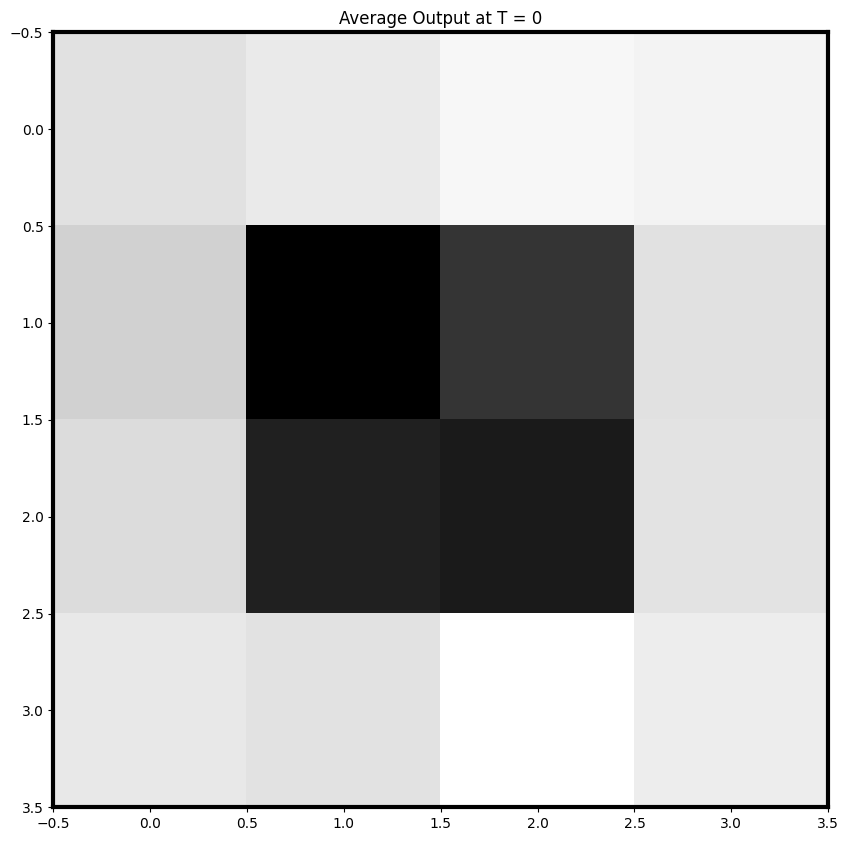

In [37]:
#visualize average output of the model
#final_output_nxn[T][Ndata][4][4]
#print_this_1 is average output of model
fig, axs = plt.subplots(1, 1, figsize = (10, 20))
num1 = np.max(np.abs(avg_backwards_vector))
print_this = np.abs(avg_backwards_vector) /num1
print_this_1 = np.zeros((4,4))
for i in range(0, 4):
    for j in range(0, 4):
        print_this_1[i][j] = print_this[0][4*i + j]


#for z in range(0, 50):
    #print(final_output_nxn[z])
#    axs[int(z / 5)][z % 5].imshow(
#        final_output_nxn[0][z]
        #print_this_1
#        , cmap = 'grey', interpolation = 'nearest')
average_output = np.zeros((n,n))
for z in range(0, 2000):
    average_output += final_output_nxn[0][z]

average_output /= 2000
axs.imshow(average_output, cmap = 'grey', interpolation = 'nearest')

plt.title('Average Output at T = %d'%0)

#plt.suptitle('Backwards Diffusion At T = 0')
#plt.tight_layout()
plt.show()